### Model Training - Neural Network (Multi-Layer Perceptron)

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import datetime
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, 
    accuracy_score, roc_auc_score, fbeta_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [30]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [31]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

In [32]:
data_df.head()

,magnitude,cdi,mmi,sig,depth,distance_to_ocean_km,gap,tsunami
0,-0.454008,0.366134,-0.750815,0.042117,-1.273282,-0.641182,19.0,0.0
1,0.480596,1.147295,0.682949,1.802154,-0.271551,-0.641182,18.0,0.0
2,1.464696,1.387524,0.682949,1.472781,0.067414,-0.641182,36.0,0.0
3,0.215003,-1.381760,-2.007214,-0.349174,-1.273282,-0.641182,16.0,0.0
4,-1.366553,0.638393,-0.053959,-1.035334,-0.610675,-0.641182,49.0,0.0


Previously in feature engineering part, we have identified longitude, latitude, dmin, nst, Year, Month, month_number do not seem to be useful. We will exclude these features.

In [33]:
features_to_exclude = ['tsunami', 'Year', 'Month','month_number','dmin','nst','longitude','latitude']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']

print(f"Features used: {X.columns.tolist()}")
print(f"Dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class ratio (negative/positive): {y.value_counts()[0] / y.value_counts()[1]:.2f}")

Features used: ['magnitude', 'cdi', 'mmi', 'sig', 'depth', 'distance_to_ocean_km', 'gap']
Dataset shape: (700, 7)
Class distribution:
tsunami
0.0    546
1.0    154
Name: count, dtype: int64
Class ratio (negative/positive): 3.55


Stratified K Fold is used to prevent the class imbalance and preserve the class ratio in every fold

In [34]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### Neural Network (MLP) Configuration
- **Architecture**: Multi-layer perceptron with 2 hidden layers
- **Dropout**: 0.5 dropout rate to prevent overfitting (critical for n=700 dataset)
- **Class Imbalance**: Handled via weighted Binary Cross Entropy loss (pos_weight)
- **Feature Scaling**: StandardScaler (essential for neural network convergence)
- **Optimizer**: Adam with learning rate 0.001
- **Batch Size**: 32 for efficient training
- **Epochs**: 100 with early stopping to prevent overfitting

In [35]:
# Calculate pos_weight for class imbalance handling
# Ratio of negative to positive samples (used in BCEWithLogitsLoss)
pos_weight = torch.tensor((y == 0).sum() / (y == 1).sum(), dtype=torch.float32)
print(f"pos_weight: {pos_weight.item():.2f}")

pos_weight: 3.55


In [36]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron for binary classification.
    Architecture: input_dim -> hidden_dim -> hidden_dim//2 -> 1 (logits)
    Uses BCEWithLogitsLoss, so output is logits (sigmoid applied in loss function).
    """
    def __init__(self, input_dim, hidden_dim=64, dropout_rate=0.5):
        super(MLP, self).__init__()
        # First hidden layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        # Dropout for regularization (prevents overfitting)
        self.dropout = nn.Dropout(p=dropout_rate)
        # Second hidden layer (reduces dimensionality)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu2 = nn.ReLU()
        # Output layer (single neuron for binary classification)
        self.output = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout(x)  # Applied during training, disabled during eval
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output(x)  # Returns logits (not probabilities)
        return x

### Cross-Validation with Training Loop


In [37]:
epochs = 100
batch_size = 32
learning_rate = 0.001
hidden_dim = 64
dropout_rate = 0.5
patience = 10

In [38]:
input_dim = X.shape[1]
results = defaultdict(list)
# Arrays to store predictions for all samples
y_pred_all = np.zeros(len(y))
y_proba_all = np.zeros(len(y))
# Dictionaries to store train predictions (avoid duplicates in CV)
y_train_pred_all = {}
y_train_proba_all = {}

# Cross-validation loop
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    # Split training fold into train and validation sets for early stopping
    X_train_inner, X_val_inner, y_train_inner, y_val_inner = train_test_split(
        X_train_fold, y_train_fold, test_size=0.2, random_state=42, stratify=y_train_fold
    )
    
    # Feature scaling (critical for neural network convergence)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_inner)
    X_val_scaled = scaler.transform(X_val_inner)
    X_test_scaled = scaler.transform(X_test_fold)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train_inner.values).unsqueeze(1)  # Shape: (n, 1)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val_inner.values).unsqueeze(1)
    
    # Create data loader for batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = MLP(input_dim=input_dim, hidden_dim=hidden_dim, dropout_rate=dropout_rate)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Handles class imbalance
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Early stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Training loop with early stopping
    for epoch in range(epochs):
        # Training phase
        model.train()  # Enable dropout
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass (returns logits)
            loss = criterion(outputs, targets)
            loss.backward()  # Backward pass
            optimizer.step()
        
        # Validation phase
        model.eval()  # Disable dropout
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
        
        # Early stopping: save best model and stop if no improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model (based on validation loss)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_scaled)
        y_test_logits = model(X_test_tensor)
        # Convert logits to probabilities using sigmoid
        y_test_proba = torch.sigmoid(y_test_logits).numpy().flatten()
        y_test_pred = (y_test_proba > 0.5).astype(int)
    
    # Store test predictions
    y_pred_all[test_idx] = y_test_pred
    y_proba_all[test_idx] = y_test_proba
    
    # Get predictions on full training fold (for train metrics)
    X_train_full_scaled = scaler.transform(X_train_fold)
    model.eval()
    with torch.no_grad():
        X_train_tensor = torch.FloatTensor(X_train_full_scaled)
        train_logits = model(X_train_tensor)
        train_proba = torch.sigmoid(train_logits).numpy().flatten()
        train_pred = (train_proba > 0.5).astype(int)
        
        # Store train predictions (avoid duplicates across folds)
        for i, idx in enumerate(train_idx):
            if idx not in y_train_pred_all:
                y_train_pred_all[idx] = train_pred[i]
                y_train_proba_all[idx] = train_proba[i]
    
    # Calculate metrics for this fold
    test_accuracy = accuracy_score(y_test_fold, y_test_pred)
    test_precision = precision_score(y_test_fold, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test_fold, y_test_pred)
    test_f1 = f1_score(y_test_fold, y_test_pred)
    test_f2 = fbeta_score(y_test_fold, y_test_pred, beta=2.0, zero_division=0)  # F2 emphasizes recall
    test_roc_auc = roc_auc_score(y_test_fold, y_test_proba)
    
    train_accuracy = accuracy_score(y_train_fold, train_pred)
    train_precision = precision_score(y_train_fold, train_pred, zero_division=0)
    train_recall = recall_score(y_train_fold, train_pred)
    train_f1 = f1_score(y_train_fold, train_pred)
    train_f2 = fbeta_score(y_train_fold, train_pred, beta=2.0, zero_division=0)
    train_roc_auc = roc_auc_score(y_train_fold, train_proba)
    
    # Store results for this fold
    results['test_accuracy'].append(test_accuracy)
    results['test_precision'].append(test_precision)
    results['test_recall'].append(test_recall)
    results['test_f1'].append(test_f1)
    results['test_f2'].append(test_f2)
    results['test_roc_auc'].append(test_roc_auc)
    results['train_accuracy'].append(train_accuracy)
    results['train_precision'].append(train_precision)
    results['train_recall'].append(train_recall)
    results['train_f1'].append(train_f1)
    results['train_f2'].append(train_f2)
    results['train_roc_auc'].append(train_roc_auc)

# Convert to numpy arrays for consistency with sklearn
for key in results:
    results[key] = np.array(results[key])

# Get final predictions (in original order)
y_pred_cv = np.array([y_train_pred_all.get(i, y_pred_all[i]) for i in range(len(y))])
y_proba_cv = np.array([y_train_proba_all.get(i, y_proba_all[i]) for i in range(len(y))])

cv_results = results

### Overfitting Analysis


In [39]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']
results_summary = []

for metric in metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    results_summary.append({
        'Metric': metric.upper(),
        'Train Mean': f"{train_scores.mean():.4f}",
        'Train Std': f"{train_scores.std():.4f}",
        'Test Mean': f"{test_scores.mean():.4f}",
        'Test Std': f"{test_scores.std():.4f}",
        'Gap': f"{train_scores.mean() - test_scores.mean():.4f}"
    })

results_df = pd.DataFrame(results_summary)
results_df

,Metric,Train Mean,Train Std,Test Mean,Test Std,Gap
0,ACCURACY,0.8204,0.0125,0.8071,0.0438,0.0132
1,PRECISION,0.5620,0.0209,0.5468,0.0780,0.0153
2,RECALL,0.8458,0.0349,0.8052,0.0500,0.0407
3,F1,0.6746,0.0144,0.6502,0.0700,0.0244
4,F2,0.7676,0.0204,0.7347,0.0599,0.0329
5,ROC_AUC,0.9071,0.0128,0.8836,0.0428,0.0235


In [40]:
for metric in metrics:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    print(f"{metric.upper():12} - Train: {train_mean:.4f}, Test: {test_mean:.4f}, Gap: {gap:+.4f}")

ACCURACY     - Train: 0.8204, Test: 0.8071, Gap: +0.0132
PRECISION    - Train: 0.5620, Test: 0.5468, Gap: +0.0153
RECALL       - Train: 0.8458, Test: 0.8052, Gap: +0.0407
F1           - Train: 0.6746, Test: 0.6502, Gap: +0.0244
F2           - Train: 0.7676, Test: 0.7347, Gap: +0.0329
ROC_AUC      - Train: 0.9071, Test: 0.8836, Gap: +0.0235


### Confusion Matrix Analysis

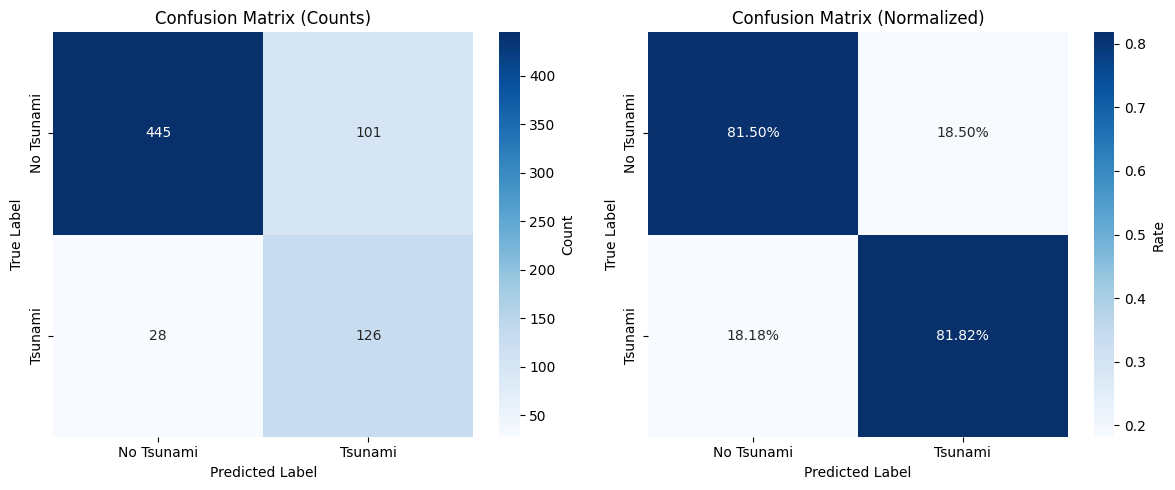


False Negative Rate: 18.18%
True Positives: 126, False Negatives: 28
True Negatives: 445, False Positives: 101


In [41]:
# Calculate confusion matrix from cross-validation predictions
cm = confusion_matrix(y, y_pred_cv)
# Normalize by row to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[0].set_yticklabels(['No Tsunami', 'Tsunami'])

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[1].set_yticklabels(['No Tsunami', 'Tsunami'])

plt.tight_layout()
plt.show()

# Calculate false negative rate (critical for tsunami detection)
fn_rate = cm[1, 0] / cm[1, :].sum() * 100
print(f"\nFalse Negative Rate: {fn_rate:.2f}%")
print(f"True Positives: {cm[1, 1]}, False Negatives: {cm[1, 0]}")
print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")


### Save Results to XLSX

In [42]:
# Save results to XLSX for model comparison
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_xlsx = results_dir / "model_results.xlsx"

# Calculate final metrics from cross-validation predictions
final_accuracy = accuracy_score(y, y_pred_cv)
final_precision = precision_score(y, y_pred_cv, zero_division=0)
final_recall = recall_score(y, y_pred_cv)
final_f1 = f1_score(y, y_pred_cv)
final_f2 = fbeta_score(y, y_pred_cv, beta=2.0, zero_division=0)
final_roc_auc = roc_auc_score(y, y_proba_cv)

mlp_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "Neural Network (MLP)",
    "cv_splits": skf.get_n_splits(),
    "scaler": "StandardScaler",
    "class_weight": f"pos_weight={pos_weight.item():.2f}",
    "test_accuracy": cv_results["test_accuracy"].mean(),
    "test_precision": cv_results["test_precision"].mean(),
    "test_recall": cv_results["test_recall"].mean(),
    "test_f1": cv_results["test_f1"].mean(),
    "test_f2": cv_results["test_f2"].mean(),
    "test_roc_auc": cv_results["test_roc_auc"].mean(),
    "train_accuracy": cv_results["train_accuracy"].mean(),
    "train_precision": cv_results["train_precision"].mean(),
    "train_recall": cv_results["train_recall"].mean(),
    "train_f1": cv_results["train_f1"].mean(),
    "train_f2": cv_results["train_f2"].mean(),
    "train_roc_auc": cv_results["train_roc_auc"].mean(),
    "train_test_gap_accuracy": cv_results["train_accuracy"].mean() - cv_results["test_accuracy"].mean(),
    "false_negative_rate": fn_rate,
    "notes": f"hidden_dim=64, dropout_rate=0.5, learning_rate=0.001, epochs=100, batch_size=32"
}

# Append to existing results or create new file
new_results_df = pd.DataFrame([mlp_results])
if results_xlsx.exists():
    existing_results = pd.read_excel(results_xlsx)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_excel(results_xlsx, index=False)
else:
    new_results_df.to_excel(results_xlsx, index=False)
    
new_results_df.T


,0
timestamp,2025-12-11 17:40:58
model,Neural Network (MLP)
cv_splits,5
scaler,StandardScaler
class_weight,pos_weight=3.55
test_accuracy,0.807143
test_precision,0.546754
test_recall,0.805161
test_f1,0.650216
test_f2,0.73468


## Neural Network (MLP) Model Results Summary

**Key Findings:**
- **Test Accuracy**: 0.8071 (80.71%)
- **Test Precision**: 0.5468 (54.68%)
- **Test Recall**: 0.8052 (80.52%) - Critical for tsunami detection
- **Test F1 Score**: 0.6502 (65.02%)
- **Test F2 Score**: 0.7347 (73.47%) - Optimized for recall (critical for tsunami detection)
- **Test ROC-AUC**: 0.8836 (88.36%) - Class separation metric
- **False Negative Rate**: 18.18% - Critical metric for safety
- **Train/Test Gap (Accuracy)**: 0.0132 (1.32%) - Overfitting indicator

**Model Configuration:**
- Class imbalance handled via weighted BCE loss with `pos_weight=3.55`
- Regularization: Dropout (0.5) to prevent overfitting on small dataset (n=700)
- Architecture: 2 hidden layers (64 → 32 neurons) with ReLU activation
- Early stopping: Prevents overfitting by monitoring validation loss
- Feature scaling: StandardScaler (essential for neural network convergence)

**Rationale:**
- **Universal Function Approximator**: MLPs can learn complex, non-linear boundaries
- **Feature Learning**: Hidden layers create derived features and interactions
- **Overfitting Mitigation**: Dropout randomly deactivates neurons during training, preventing co-adaptations
- **Complementary Approach**: Provides different inductive bias than tree-based models
